In [1]:
#importing necessary libraries
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.seasonal import STL

In [2]:
df = pd.read_csv('/content/Walmart DataSet.csv')


In [3]:
# normalize column names (if applicable)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [4]:
# parse date
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [5]:
# quick sanity
print("Rows, Columns:", df.shape)
print(df.dtypes)
print(df.head())


Rows, Columns: (6435, 8)
store                    int64
date            datetime64[ns]
weekly_sales           float64
holiday_flag             int64
temperature            float64
fuel_price             float64
cpi                    float64
unemployment           float64
dtype: object
   store       date  weekly_sales  holiday_flag  temperature  fuel_price  \
0      1 2010-05-02    1643690.90             0        42.31       2.572   
1      1 2010-12-02    1641957.44             1        38.51       2.548   
2      1        NaT    1611968.17             0        39.93       2.514   
3      1        NaT    1409727.59             0        46.63       2.561   
4      1 2010-05-03    1554806.68             0        46.50       2.625   

          cpi  unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  


In [6]:
# 2. Feature engineering
df['date'] = df['date'].fillna(pd.to_datetime('1900-01-01')) # Fill NaT with a placeholder date
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month.astype(int)
df['month_name'] = df['date'].dt.month_name().str.slice(stop=3)
df['week'] = df['date'].dt.isocalendar().week.astype(int)
df['holiday_flag'] = df['holiday_flag'].fillna(0).astype(int) # Ensure holiday_flag is int after filling NaN

In [7]:
# Ensure numeric
numeric_cols = ['weekly_sales','temperature','fuel_price','cpi','unemployment']
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')


In [8]:
# Quick summary
print("Columns present:", df.columns.tolist())
print("Missing values per column:\n", df.isna().sum())

Columns present: ['store', 'date', 'weekly_sales', 'holiday_flag', 'temperature', 'fuel_price', 'cpi', 'unemployment', 'year', 'month', 'month_name', 'week']
Missing values per column:
 store           0
date            0
weekly_sales    0
holiday_flag    0
temperature     0
fuel_price      0
cpi             0
unemployment    0
year            0
month           0
month_name      0
week            0
dtype: int64


In [9]:
#3. Missing value handling
#print_headline("MISSING VALUE IMPUTATION")
# Strategy: median imputation within-store for numeric fields; fallback to global median
def impute_median_by_store(df, col):
    if col not in df.columns:
        return df
    df[col] = df.groupby('store')[col].transform(lambda s: s.fillna(s.median()))
    df[col] = df[col].fillna(df[col].median())
    return df

for col in numeric_cols:
    df = impute_median_by_store(df, col)

In [10]:
# Holiday flag: fill missing with 0 and ensure int
if 'holiday_flag' in df.columns:
    df['holiday_flag'] = df['holiday_flag'].fillna(0).astype(int)
else:
    df['holiday_flag'] = 0

print("Missing after imputation:\n", df.isna().sum())

Missing after imputation:
 store           0
date            0
weekly_sales    0
holiday_flag    0
temperature     0
fuel_price      0
cpi             0
unemployment    0
year            0
month           0
month_name      0
week            0
dtype: int64


In [11]:
# 4. Outlier analysis & treatment
#print_headline("OUTLIER ANALYSIS")
# show some stats
OUT_DIR = './output' # Define OUT_DIR
os.makedirs(OUT_DIR, exist_ok=True) # Create the directory if it doesn't exist
stats_summary = df[numeric_cols].describe().transpose()
stats_summary.to_csv(os.path.join(OUT_DIR, "numeric_summary_before_outlier.csv"))
print(stats_summary)

               count          mean            std         min         25%  \
weekly_sales  6435.0  1.046965e+06  564366.622054  209986.250  553350.105   
temperature   6435.0  6.066378e+01      18.444933      -2.060      47.460   
fuel_price    6435.0  3.358607e+00       0.459020       2.472       2.933   
cpi           6435.0  1.715784e+02      39.356712     126.064     131.735   
unemployment  6435.0  7.999151e+00       1.875885       3.879       6.891   

                        50%           75%           max  
weekly_sales  960746.040000  1.420159e+06  3.818686e+06  
temperature       62.670000  7.494000e+01  1.001400e+02  
fuel_price         3.445000  3.735000e+00  4.468000e+00  
cpi              182.616521  2.127433e+02  2.272328e+02  
unemployment       7.874000  8.622000e+00  1.431300e+01  


In [12]:
# IQR capping per-store for weekly_sales
def cap_iqr_per_group(df, col, group_col='store'):
    def cap_series(s):
        q1 = s.quantile(0.25)
        q3 = s.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        return s.clip(lower=lower, upper=upper)
    cap_col = col + "_cap"
    df[cap_col] = df.groupby(group_col)[col].transform(cap_series)
    # fallback if any NaNs
    df[cap_col] = df[cap_col].fillna(df[col].median())
    return df

df = cap_iqr_per_group(df, 'weekly_sales', 'store')
df['log_sales'] = np.log1p(df['weekly_sales'])
df['log_sales_cap'] = np.log1p(df['weekly_sales_cap'])

print("Outlier capping done. Example ranges (capped column):")
print(df['weekly_sales_cap'].describe())

Outlier capping done. Example ranges (capped column):
count    6.435000e+03
mean     1.034505e+06
std      5.438203e+05
min      2.099862e+05
25%      5.527446e+05
50%      9.552117e+05
75%      1.410433e+06
max      2.543180e+06
Name: weekly_sales_cap, dtype: float64


Text(0, 0.5, 'Total Weekly Sales')

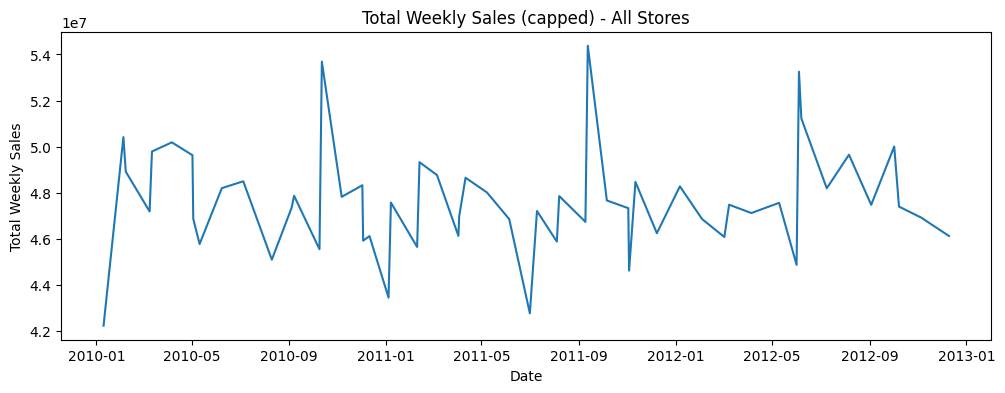

In [13]:
#5.Perform Exploratory Data Analysis (EDA)
#print_headline("EXPLORATORY DATA ANALYSIS (EDA)")
# a) Overall time series plot (total weekly sales across all stores)
ts = df[df['date'] != pd.to_datetime('1900-01-01')].groupby('date').agg(total_sales=('weekly_sales_cap','sum')).reset_index()
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(ts['date'], ts['total_sales'])
ax.set_title("Total Weekly Sales (capped) - All Stores")
ax.set_xlabel("Date"); ax.set_ylabel("Total Weekly Sales")
#safe_savefig(fig, "timeseries_total_weekly_sales.png")

Text(0.5, 1.0, 'Correlation Matrix')

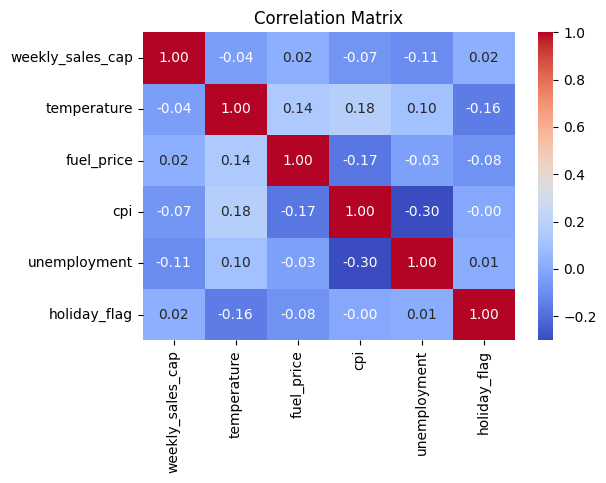

In [14]:
# b) Correlation heatmap among numeric vars
corr_cols = ['weekly_sales_cap','temperature','fuel_price','cpi','unemployment','holiday_flag']
corr_df = df[corr_cols].corr()
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm', ax=ax)
ax.set_title("Correlation Matrix")
#safe_savefig(fig, "corr_matrix.png")


Text(0, 0.5, 'Mean Weekly Sales')

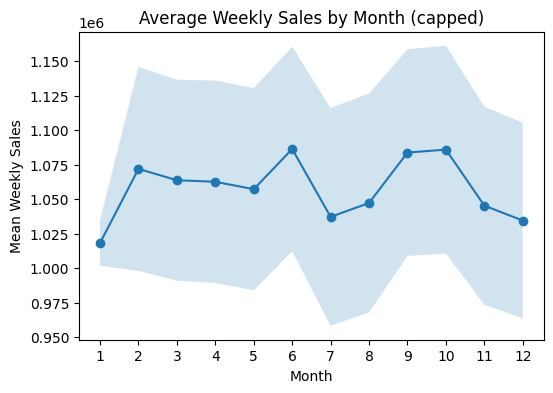

In [15]:
# c) Average sales by month (seasonality view)
monthly = df.groupby('month').agg(mean_sales=('weekly_sales_cap','mean'),
                                  median_sales=('weekly_sales_cap','median'),
                                  sd=('weekly_sales_cap','std'),
                                  n=('weekly_sales_cap','count')).reset_index().sort_values('month')
monthly['se'] = monthly['sd']/np.sqrt(monthly['n'])
monthly['ci_low'] = monthly['mean_sales'] - 1.96*monthly['se']
monthly['ci_high'] = monthly['mean_sales'] + 1.96*monthly['se']
monthly.to_csv(os.path.join(OUT_DIR, "monthly_summary.csv"), index=False)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(monthly['month'], monthly['mean_sales'], marker='o')
ax.fill_between(monthly['month'], monthly['ci_low'], monthly['ci_high'], alpha=0.2)
ax.set_xticks(monthly['month'])
ax.set_title("Average Weekly Sales by Month (capped)")
ax.set_xlabel("Month"); ax.set_ylabel("Mean Weekly Sales")
#safe_savefig(fig, "avg_sales_by_month.png")

Text(0.5, 1.0, 'Sales vs Unemployment (sampled points + LOWESS)')

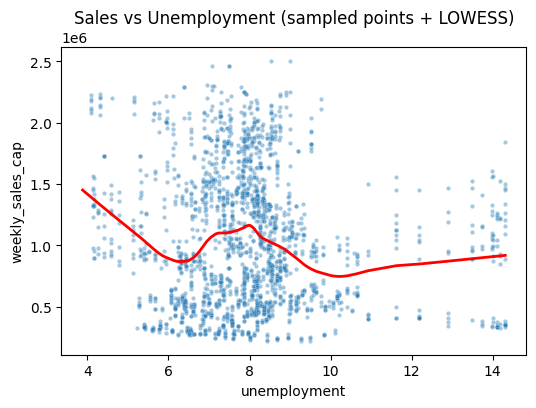

In [16]:
# d) Sales vs Unemployment scatter (all stores) with LOESS-like smoothing (lowess)
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=df.sample(min(len(df), 2000), random_state=1), x='unemployment', y='weekly_sales_cap', alpha=0.4, s=10, ax=ax)
# lowess from statsmodels
lowess = sm.nonparametric.lowess(df['weekly_sales_cap'], df['unemployment'], frac=0.3)
ax.plot(lowess[:,0], lowess[:,1], color='red', linewidth=2)
ax.set_title("Sales vs Unemployment (sampled points + LOWESS)")
#safe_savefig(fig, "sales_vs_unemployment_lowess.png")

Text(0, 0.5, 'Mean Weekly Sales')

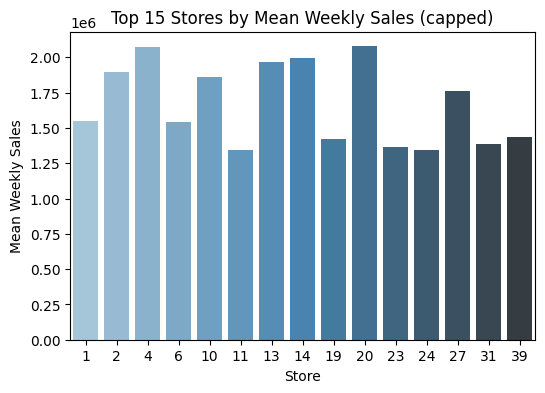

In [17]:

# e) Top and bottom stores by mean sales
store_perf = df.groupby('store').agg(mean_sales=('weekly_sales_cap','mean'),
                                    median_sales=('weekly_sales_cap','median'),
                                    sd=('weekly_sales_cap','std'),
                                    n=('weekly_sales_cap','count')).reset_index()
store_perf['se'] = store_perf['sd']/np.sqrt(store_perf['n'])
store_perf = store_perf.sort_values('mean_sales', ascending=False)
store_perf.to_csv(os.path.join(OUT_DIR, "store_performance_summary.csv"), index=False)

fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=store_perf.head(15), x='store', y='mean_sales', palette="Blues_d", ax=ax)
ax.set_title("Top 15 Stores by Mean Weekly Sales (capped)")
ax.set_xlabel("Store"); ax.set_ylabel("Mean Weekly Sales")
#safe_savefig(fig, "top15_stores_mean_sales.png")



In [18]:
# 6. Statistical analyses & tests
#print_headline("STATISTICAL ANALYSES")
#a) Test whether month has a significant effect on sales (ANOVA)
df['month_factor'] = df['month'].astype('category')
anova_model = smf.ols('weekly_sales_cap ~ C(month_factor)', data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print("ANOVA (month effect) table:\n", anova_table)
anova_table.to_csv(os.path.join(OUT_DIR, "anova_month_effect.csv"))


ANOVA (month effect) table:
                        sum_sq      df         F    PR(>F)
C(month_factor)  3.670618e+12    11.0  1.128577  0.333552
Residual         1.899124e+15  6423.0       NaN       NaN


In [19]:
# Define global_model, cpi_model, and temp_mod
global_model = smf.ols('weekly_sales_cap ~ unemployment', data=df).fit()
df['log_cpi'] = np.log1p(df['cpi'])
cpi_model = smf.ols('weekly_sales_cap ~ log_cpi', data=df).fit()
df['temp2'] = df['temperature']**2
temp_mod = smf.ols('weekly_sales_cap ~ temperature + temp2', data=df).fit()


In [20]:
# 7. Insights & Summaries to file
#print_headline("GENERATE SUMMARY INSIGHTS FILES")
best_store = store_perf.iloc[0]
worst_store = store_perf.iloc[-1]
gap_abs = best_store['mean_sales'] - worst_store['mean_sales']
gap_pct = gap_abs / best_store['mean_sales'] * 100
summary_lines = [
    f"Dataset rows: {df.shape[0]}, stores: {df['store'].nunique()}",
    f"Best store (mean weekly sales, capped): Store {best_store['store']} = {best_store['mean_sales']:.2f}",
    f"Worst store (mean weekly sales, capped): Store {worst_store['store']} = {worst_store['mean_sales']:.2f}",
    f"Absolute gap (best - worst): {gap_abs:.2f}, Percent gap: {gap_pct:.2f}%",
    f"ANOVA (month) p-value: {anova_table['PR(>F)'].iloc[0] if 'PR(>F)' in anova_table.columns else 'NA'}",
    f"Global regression unemployment coef: {global_model.params.get('unemployment'):.4f}, p: {global_model.pvalues.get('unemployment'):.4f}",
    f"Global CPI elasticity (log_cpi coef): {cpi_model.params.get('log_cpi'):.4f}, p: {cpi_model.pvalues.get('log_cpi'):.4f}",
    f"Temperature linear coef: {temp_mod.params.get('temperature'):.6f}, temp^2 coef: {temp_mod.params.get('temp2'):.6f}"
]
with open(os.path.join(OUT_DIR, "analysis_summary.txt"), "w") as f:
    f.write("\n".join(summary_lines))
print("Summary written to outputs/analysis_summary.txt")
print("\n".join(summary_lines))


Summary written to outputs/analysis_summary.txt
Dataset rows: 6435, stores: 45
Best store (mean weekly sales, capped): Store 20.0 = 2077384.93
Worst store (mean weekly sales, capped): Store 33.0 = 259790.44
Absolute gap (best - worst): 1817594.49, Percent gap: 87.49%
ANOVA (month) p-value: 0.33355195345847327
Global regression unemployment coef: -31411.6090, p: 0.0000
Global CPI elasticity (log_cpi coef): -165873.4547, p: 0.0000
Temperature linear coef: 11494.616189, temp^2 coef: -110.486117


In [21]:
#PROBLEM QUESTIONS
#1a) If the weekly sales are affected by the unemployment rate, if yes - which stores are suffering the most?
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

In [22]:
# Load dataset
df = pd.read_csv("Walmart DataSet.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [23]:
# Fill missing values with median per store
for col in ['weekly_sales','temperature','fuel_price','cpi','unemployment']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df.groupby('store')[col].transform(lambda x: x.fillna(x.median()))
df['log_sales'] = np.log1p(df['weekly_sales'])

In [24]:
# Run per-store regression and collect unemployment effects
results = []
for s, g in df.groupby('store'):   #s is store number and g is data subset for that store
    if len(g) < 20: continue
    m = smf.ols('log_sales ~ unemployment + cpi + fuel_price + temperature + holiday_flag', data=g).fit()   #statsmodel formula for ordinary least squarte regression
    results.append([s, m.params['unemployment'], m.pvalues['unemployment']])

res = pd.DataFrame(results, columns=['store','coef_unemployment','pvalue'])
res['effect'] = np.where((res['coef_unemployment']<0)&(res['pvalue']<0.05),
                         'Negative & significant','Not significant')
print("Stores most suffering from unemployment:\n")
print(res[res['effect']=='Negative & significant'].sort_values('coef_unemployment').head(10))


Stores most suffering from unemployment:

    store  coef_unemployment    pvalue                  effect
29     30          -0.086893  0.001985  Negative & significant
43     44          -0.077275  0.002523  Negative & significant
42     43          -0.055735  0.000551  Negative & significant
37     38          -0.026321  0.009326  Negative & significant


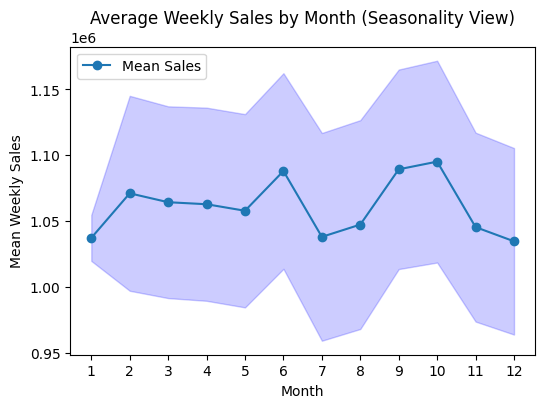

ANOVA (month effect) table:
                        sum_sq      df         F    PR(>F)
C(month_factor)  2.021978e+12    11.0  0.576696  0.849385
Residual         2.047269e+15  6423.0       NaN       NaN


In [26]:
#1b. If the weekly sales show a seasonal trend, when and what could be the reason?
# Seasonality analysis
# Group by month

# Fill NaT values in date column with a default date before extracting month
df['date'] = df['date'].fillna(pd.to_datetime('1900-01-01'))

# Extract month from date column
df['month'] = df['date'].dt.month.astype(int)

monthly = df.groupby('month').agg(
    mean_sales=('weekly_sales','mean'),
    median_sales=('weekly_sales','median'),
    sd=('weekly_sales','std'),
    n=('weekly_sales','count')
).reset_index()

# Confidence interval
monthly['se'] = monthly['sd'] / np.sqrt(monthly['n'])
monthly['ci_low'] = monthly['mean_sales'] - 1.96 * monthly['se']
monthly['ci_high'] = monthly['mean_sales'] + 1.96 * monthly['se']

# Plot average sales by month
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(monthly['month'], monthly['mean_sales'], marker='o', label='Mean Sales')
ax.fill_between(monthly['month'], monthly['ci_low'], monthly['ci_high'], color='blue', alpha=0.2)
ax.set_xticks(range(1,13))
ax.set_title("Average Weekly Sales by Month (Seasonality View)")
ax.set_xlabel("Month"); ax.set_ylabel("Mean Weekly Sales")
plt.legend()
plt.show()

#ANOVA test
df['month_factor'] = df['month'].astype('category')
anova_model = smf.ols('weekly_sales ~ C(month_factor)', data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print("ANOVA (month effect) table:\n", anova_table)



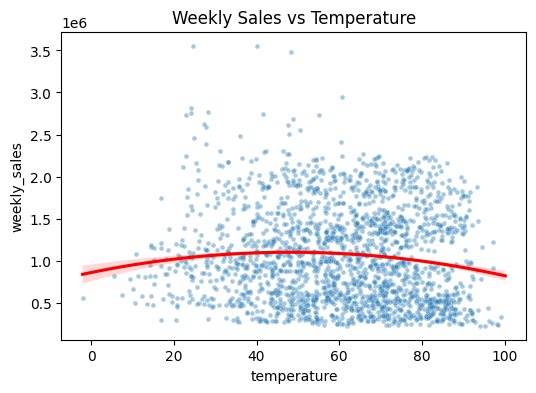

                            OLS Regression Results                            
Dep. Variable:           weekly_sales   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     34.20
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           6.97e-41
Time:                        10:39:42   Log-Likelihood:                -94251.
No. Observations:                6435   AIC:                         1.885e+05
Df Residuals:                    6428   BIC:                         1.886e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      1.43e+06   9.35e+04     15.291   

In [27]:
#1c. Does temperature affect the weekly sales in any manner?


import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import statsmodels.formula.api as smf

# Load dataset
df = pd.read_csv("Walmart DataSet.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Fill missing values with median per store
for col in ['weekly_sales','temperature','fuel_price','cpi','unemployment']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df.groupby('store')[col].transform(lambda x: x.fillna(x.median()))

# Add squared term for non-linear effect
df['temp2'] = df['temperature']**2

# Visualization
plt.figure(figsize=(6,4))
sns.scatterplot(x='temperature', y='weekly_sales', data=df.sample(2000, random_state=1), alpha=0.4, s=12)
sns.regplot(x='temperature', y='weekly_sales', data=df, scatter=False, order=2, color='red')
plt.title("Weekly Sales vs Temperature")
plt.show()

#  Regression Model
model = smf.ols("weekly_sales ~ temperature + temp2 + cpi + unemployment + fuel_price + holiday_flag", data=df).fit()
print(model.summary())


In [28]:
#1d. How is the Consumer Price index affecting the weekly sales of various stores?

# Run per-store regression: log_sales ~ CPI (+ controls)
results = []
for s, g in df.groupby('store'):
    if len(g) < 20: continue
    # Add log_sales column to the grouped dataframe 'g'
    g['log_sales'] = np.log1p(g['weekly_sales'])
    m = smf.ols('log_sales ~ cpi + unemployment + fuel_price + temperature + holiday_flag', data=g).fit()
    results.append([s, m.params['cpi'], m.pvalues['cpi']])

# Collect results in DataFrame
res_cpi = pd.DataFrame(results, columns=['store','coef_cpi','pvalue'])
res_cpi['effect'] = np.where((res_cpi['coef_cpi']<0)&(res_cpi['pvalue']<0.05),
                             'Negative & significant','Not significant')

# Show stores most negatively affected by CPI
print("Stores most negatively affected by CPI:\n")
print(res_cpi[res_cpi['effect']=='Negative & significant'].sort_values('coef_cpi').head(10))

# Save to CSV for reporting
res_cpi.to_csv("cpi_effects_per_store.csv", index=False)


Stores most negatively affected by CPI:

    store  coef_cpi        pvalue                  effect
35     36 -0.044487  5.390684e-11  Negative & significant
34     35 -0.030004  6.894608e-03  Negative & significant
13     14 -0.018611  4.375339e-04  Negative & significant
29     30 -0.013328  4.835027e-03  Negative & significant
42     43 -0.008095  4.609583e-03  Negative & significant


Top 10 Performing Stores:

    store  weekly_sales
19     20  2.107677e+06
3       4  2.094713e+06
13     14  2.020978e+06
12     13  2.003620e+06
1       2  1.925751e+06
9      10  1.899425e+06
26     27  1.775216e+06
5       6  1.564728e+06
0       1  1.555264e+06
38     39  1.450668e+06


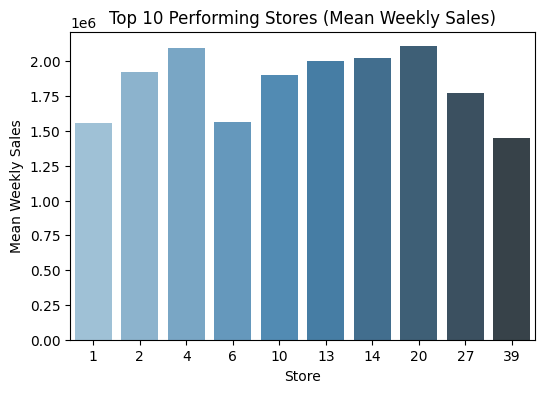

In [29]:
#1e. Top performing stores according to the historical data.

# Compute store performance (mean weekly sales)
store_perf = df.groupby('store')['weekly_sales'].mean().reset_index().sort_values('weekly_sales', ascending=False)

# Display top 10 stores
print("Top 10 Performing Stores:\n")
print(store_perf.head(10))

# Plot Top 10 Stores
plt.figure(figsize=(6,4))
sns.barplot(x='store', y='weekly_sales', data=store_perf.head(10), palette="Blues_d")
plt.title("Top 10 Performing Stores (Mean Weekly Sales)")
plt.xlabel("Store")
plt.ylabel("Mean Weekly Sales")
plt.show()


In [30]:
#1f. The worst performing store, and how significant is the difference between the highest and lowest performing stores.

# Compute mean sales per store
store_perf = df.groupby('store')['weekly_sales'].mean().reset_index()

# Identify best and worst stores
best_store = store_perf.loc[store_perf['weekly_sales'].idxmax()]
worst_store = store_perf.loc[store_perf['weekly_sales'].idxmin()]

# Calculate sales gap
gap_abs = best_store['weekly_sales'] - worst_store['weekly_sales']
gap_pct = (gap_abs / best_store['weekly_sales']) * 100

# Print results
print(f"Best Store: {int(best_store['store'])} with mean weekly sales = {best_store['weekly_sales']:.2f}")
print(f"Worst Store: {int(worst_store['store'])} with mean weekly sales = {worst_store['weekly_sales']:.2f}")
print(f"Absolute Gap = {gap_abs:.2f}, Percent Gap = {gap_pct:.2f}%")


Best Store: 20 with mean weekly sales = 2107676.87
Worst Store: 33 with mean weekly sales = 259861.69
Absolute Gap = 1847815.18, Percent Gap = 87.67%


In [31]:
#2. Use predictive modeling techniques to forecast the sales for each store for the next 12 weeks.

import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Load dataset
df = pd.read_csv("Walmart DataSet.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Handle missing values in numeric columns (median per store)
for col in ['weekly_sales','temperature','fuel_price','cpi','unemployment']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df.groupby('store')[col].transform(lambda x: x.fillna(x.median()))

# Fill NaT values in date column with a placeholder date before sorting
df['date'] = df['date'].fillna(pd.to_datetime('1900-01-01'))

# Sort by store and date to ensure monotonic time series for each store
df = df.sort_values(by=['store', 'date'])


In [33]:
for store, g in df.groupby('store'):
    # Ensure dates are unique and sorted for the time series
    g = g.drop_duplicates(subset=['date']).sort_values('date')

    # Exclude placeholder dates for time series analysis
    g_ts = g[g['date'] != pd.to_datetime('1900-01-01')].copy()

    if len(g_ts) < 2: # Need at least two points to fit a time series model
        print(f"Store {store} has insufficient data for forecasting.")
        continue

    ts = g_ts.set_index('date')['weekly_sales']

    # Fit ARIMA model
    try:
        model = ARIMA(ts, order=(1,1,1))
        results = model.fit()

        # Forecast next 12 weeks
        forecast = results.get_forecast(steps=12)
        forecast_df = forecast.summary_frame()[['mean','mean_ci_lower','mean_ci_upper']]
        forecast_results[store] = forecast_df

        print(f"\nStore {store} - Next 12 Weeks Forecast:")
        print(forecast_df)

    except Exception as e:
        print(f"Store {store} - Model failed: {e}")

print(df['date'].head())
print(df['date'].tail())
print(df['date'].dtype)
print(df['date'].isnull().sum())
print(df['date'].is_monotonic_increasing)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p


Store 1 - Next 12 Weeks Forecast:
weekly_sales          mean  mean_ci_lower  mean_ci_upper
57            1.576093e+06   1.406485e+06   1.745701e+06
58            1.577038e+06   1.343813e+06   1.810262e+06
59            1.577333e+06   1.296128e+06   1.858538e+06
60            1.577425e+06   1.255763e+06   1.899088e+06
61            1.577454e+06   1.220010e+06   1.934898e+06
62            1.577463e+06   1.187544e+06   1.967383e+06
63            1.577466e+06   1.157586e+06   1.997347e+06
64            1.577467e+06   1.129629e+06   2.025306e+06
65            1.577467e+06   1.103318e+06   2.051617e+06
66            1.577468e+06   1.078392e+06   2.076543e+06
67            1.577468e+06   1.054654e+06   2.100282e+06
68            1.577468e+06   1.031947e+06   2.122988e+06

Store 2 - Next 12 Weeks Forecast:
weekly_sales          mean  mean_ci_lower  mean_ci_upper
57            1.913838e+06   1.650154e+06   2.177522e+06
58            1.905383e+06   1.547127e+06   2.263639e+06
59            1.91

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/p


Store 5 - Next 12 Weeks Forecast:
weekly_sales           mean  mean_ci_lower  mean_ci_upper
57            326058.698269  276325.447121  375791.949418
58            326099.607278  260901.874468  391297.340087
59            326101.953520  248696.194262  403507.712777
60            326102.088083  238178.938513  414025.237653
61            326102.095801  228792.334101  423411.857500
62            326102.096243  220234.762380  431969.430106
63            326102.096269  212318.992759  439885.199779
64            326102.096270  204919.189526  447285.003014
65            326102.096270  197945.944922  454258.247618
66            326102.096270  191333.029457  460871.163083
67            326102.096270  185029.761594  467174.430946
68            326102.096270  178996.332099  473207.860441

Store 6 - Next 12 Weeks Forecast:
weekly_sales          mean  mean_ci_lower  mean_ci_upper
57            1.472595e+06   1.189541e+06   1.755648e+06
58            1.482262e+06   1.100005e+06   1.864518e+06
59   

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/p


Store 10 - Next 12 Weeks Forecast:
weekly_sales          mean  mean_ci_lower  mean_ci_upper
57            1.769495e+06   1.392149e+06   2.146841e+06
58            1.775440e+06   1.326283e+06   2.224596e+06
59            1.776075e+06   1.271763e+06   2.280388e+06
60            1.776143e+06   1.222770e+06   2.329517e+06
61            1.776150e+06   1.177787e+06   2.374514e+06
62            1.776151e+06   1.135958e+06   2.416345e+06
63            1.776151e+06   1.096699e+06   2.455604e+06
64            1.776151e+06   1.059587e+06   2.492715e+06
65            1.776151e+06   1.024306e+06   2.527997e+06
66            1.776151e+06   9.906072e+05   2.561695e+06
67            1.776151e+06   9.582959e+05   2.594007e+06
68            1.776151e+06   9.272136e+05   2.625089e+06

Store 11 - Next 12 Weeks Forecast:
weekly_sales          mean  mean_ci_lower  mean_ci_upper
57            1.318617e+06   1.100579e+06   1.536656e+06
58            1.320385e+06   1.033989e+06   1.606780e+06
59            1.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/p


Store 16 - Next 12 Weeks Forecast:
weekly_sales           mean  mean_ci_lower  mean_ci_upper
57            507854.973149  365922.665936  649787.280361
58            514007.798331  356734.751499  671280.845163
59            516368.302734  354261.836196  678474.769272
60            517273.899898  352703.433908  681844.365887
61            517621.328279  351283.634254  683959.022303
62            517754.617654  349891.946615  685617.288692
63            517805.753538  348512.909424  687098.597652
64            517825.371596  347144.600065  688506.143126
65            517832.897978  345786.827610  689878.968345
66            517835.785441  344439.505373  691232.065510
67            517836.893204  343102.486656  692571.299752
68            517837.318192  341775.583112  693899.053273

Store 17 - Next 12 Weeks Forecast:
weekly_sales           mean  mean_ci_lower  mean_ci_upper
57            928199.722553  704073.871095   1.152326e+06
58            932891.210206  657234.357819   1.208548e+06


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/p


Store 21 - Next 12 Weeks Forecast:
weekly_sales           mean  mean_ci_lower  mean_ci_upper
57            657626.430716  521026.959304   7.942259e+05
58            658511.727456  482657.606783   8.343658e+05
59            658682.740309  453478.469266   8.638870e+05
60            658715.774877  428303.495703   8.891281e+05
61            658722.156168  405677.048708   9.117673e+05
62            658723.388843  384923.634627   9.325231e+05
63            658723.626959  365637.751615   9.518095e+05
64            658723.672955  347545.148040   9.699022e+05
65            658723.681841  330448.242377   9.869991e+05
66            658723.683557  314198.730235   1.003249e+06
67            658723.683889  298681.851953   1.018766e+06
68            658723.683953  283806.629614   1.033641e+06

Store 22 - Next 12 Weeks Forecast:
weekly_sales          mean  mean_ci_lower  mean_ci_upper
57            1.007449e+06  806426.268770   1.208471e+06
58            1.009540e+06  757326.223976   1.261754e+06
59 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/p


Store 26 - Next 12 Weeks Forecast:
weekly_sales          mean  mean_ci_lower  mean_ci_upper
57            1.044096e+06  892996.665313   1.195195e+06
58            1.044360e+06  840034.973708   1.248686e+06
59            1.044232e+06  794182.462656   1.294281e+06
60            1.044294e+06  757265.317853   1.331323e+06
61            1.044264e+06  723812.435876   1.364715e+06
62            1.044279e+06  693883.588332   1.394673e+06
63            1.044271e+06  666158.791643   1.422384e+06
64            1.044275e+06  640405.420947   1.448144e+06
65            1.044273e+06  616164.791551   1.472381e+06
66            1.044274e+06  593240.799670   1.495307e+06
67            1.044274e+06  571419.507045   1.517128e+06
68            1.044274e+06  550565.202846   1.537982e+06

Store 27 - Next 12 Weeks Forecast:
weekly_sales          mean  mean_ci_lower  mean_ci_upper
57            1.666532e+06   1.292676e+06   2.040388e+06
58            1.671618e+06   1.168534e+06   2.174702e+06
59            1.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/p


Store 32 - Next 12 Weeks Forecast:
weekly_sales          mean  mean_ci_lower  mean_ci_upper
57            1.177366e+06   1.017736e+06   1.336995e+06
58            1.177737e+06   9.616726e+05   1.393802e+06
59            1.177940e+06   9.215687e+05   1.434310e+06
60            1.178049e+06   8.888390e+05   1.467260e+06
61            1.178109e+06   8.603638e+05   1.495854e+06
62            1.178141e+06   8.346866e+05   1.521596e+06
63            1.178159e+06   8.110247e+05   1.545293e+06
64            1.178169e+06   7.889123e+05   1.567425e+06
65            1.178174e+06   7.680486e+05   1.588299e+06
66            1.178177e+06   7.482263e+05   1.608127e+06
67            1.178178e+06   7.292940e+05   1.627062e+06
68            1.178179e+06   7.111366e+05   1.645222e+06

Store 33 - Next 12 Weeks Forecast:
weekly_sales           mean  mean_ci_lower  mean_ci_upper
57            291759.212525  248970.330959  334548.094091
58            291747.294600  233276.887670  350217.701529
59           

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p


Store 36 - Next 12 Weeks Forecast:
weekly_sales           mean  mean_ci_lower  mean_ci_upper
57            303591.415066  231327.221049  375855.609082
58            304838.887639  210279.553844  399398.221434
59            305302.789155  194999.248105  415606.330206
60            305475.301659  182115.823292  428834.780027
61            305539.454422  170615.327085  440463.581759
62            305563.311110  160071.210594  451055.411626
63            305572.182771  150257.480424  460886.885118
64            305575.481903  141033.327311  470117.636495
65            305576.708762  132301.264721  478852.152803
66            305577.164998  123989.196420  487165.133576
67            305577.334659  116041.494910  495113.174409
68            305577.397752  108413.971095  502740.824409

Store 37 - Next 12 Weeks Forecast:
weekly_sales           mean  mean_ci_lower  mean_ci_upper
57            521800.977676  480840.724482  562761.230871
58            521797.200268  466055.803256  577538.597280


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/p


Store 39 - Next 12 Weeks Forecast:
weekly_sales          mean  mean_ci_lower  mean_ci_upper
57            1.500430e+06   1.247415e+06   1.753444e+06
58            1.504455e+06   1.167894e+06   1.841016e+06
59            1.507150e+06   1.115066e+06   1.899233e+06
60            1.508954e+06   1.074469e+06   1.943439e+06
61            1.510161e+06   1.040671e+06   1.979651e+06
62            1.510970e+06   1.011086e+06   2.010853e+06
63            1.511511e+06   9.843212e+05   2.038701e+06
64            1.511873e+06   9.595639e+05   2.064183e+06
65            1.512116e+06   9.363128e+05   2.087919e+06
66            1.512278e+06   9.142431e+05   2.110313e+06
67            1.512387e+06   8.931353e+05   2.131638e+06
68            1.512460e+06   8.728358e+05   2.152083e+06

Store 40 - Next 12 Weeks Forecast:
weekly_sales           mean  mean_ci_lower  mean_ci_upper
57            981133.086575  823140.132450   1.139126e+06
58            982136.255822  769860.289622   1.194412e+06
59           

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/p


Store 41 - Next 12 Weeks Forecast:
weekly_sales          mean  mean_ci_lower  mean_ci_upper
57            1.403430e+06   1.178826e+06   1.628034e+06
58            1.399788e+06   1.104177e+06   1.695398e+06
59            1.397618e+06   1.055162e+06   1.740074e+06
60            1.396325e+06   1.017746e+06   1.774905e+06
61            1.395556e+06   9.866492e+05   1.804462e+06
62            1.395097e+06   9.593884e+05   1.830805e+06
63            1.394824e+06   9.346564e+05   1.854991e+06
64            1.394661e+06   9.117122e+05   1.877610e+06
65            1.394564e+06   8.901110e+05   1.899017e+06
66            1.394506e+06   8.695712e+05   1.919441e+06
67            1.394472e+06   8.499060e+05   1.939038e+06
68            1.394451e+06   8.309851e+05   1.957918e+06


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/p


Store 42 - Next 12 Weeks Forecast:
weekly_sales           mean  mean_ci_lower  mean_ci_upper
57            613698.355579  552911.616427  674485.094731
58            613688.236313  529666.519558  697709.953068
59            613688.313979  511576.869489  715799.758469
60            613688.313383  496241.192129  731135.434637
61            613688.313388  482688.673572  744687.953203
62            613688.313388  470412.408325  756964.218450
63            613688.313388  459108.029033  768268.597742
64            613688.313388  448575.795234  778800.831541
65            613688.313388  438676.248116  788700.378660
66            613688.313388  429307.451228  798069.175547
67            613688.313388  420392.214952  806984.411823
68            613688.313388  411870.422679  815506.204096

Store 43 - Next 12 Weeks Forecast:
weekly_sales           mean  mean_ci_lower  mean_ci_upper
57            621574.769744  559605.081456  683544.458032
58            621178.789596  538087.542490  704270.036703


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/p

In [34]:
#Forecast Visualization

# Function to plot forecast for a given store
def plot_store_forecast(store_id, df, forecast_results):
    # Original data
    g = df[df['store'] == store_id][['date','weekly_sales']].sort_values('date')

    # Forecasted data (last 12 weeks)
    if store_id not in forecast_results:
        print(f"No forecast available for Store {store_id}")
        return
    forecast = forecast_results[store_id]

    plt.figure(figsize=(8,6))

    # Plot historical sales
    plt.plot(g['date'], g['weekly_sales'], label='Historical Sales', color='blue')

    # Plot forecast line
    plt.plot(forecast.index, forecast['mean'], label='Forecast Sales', color='red')

    # Plot confidence interval
    plt.fill_between(forecast.index, forecast['mean_ci_lower'], forecast['mean_ci_upper'],
                     color='pink', alpha=0.3, label='Confidence Interval')

    plt.title(f"Store {store_id} - 12 Weeks Sales Forecast")
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales")
    plt.legend()
    plt.show()


Plotting forecasts for the top 5 stores: [20, 4, 14, 13, 2]


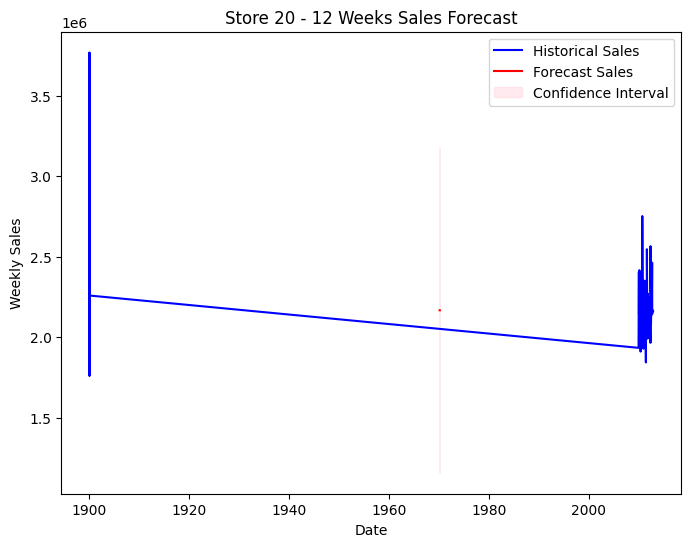

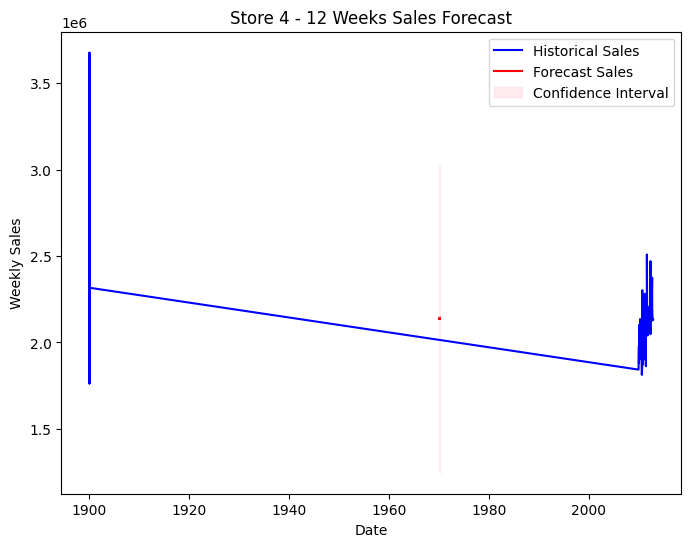

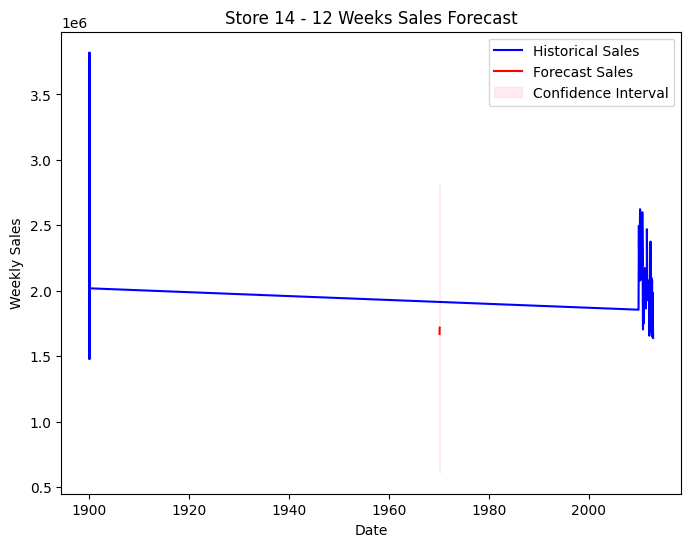

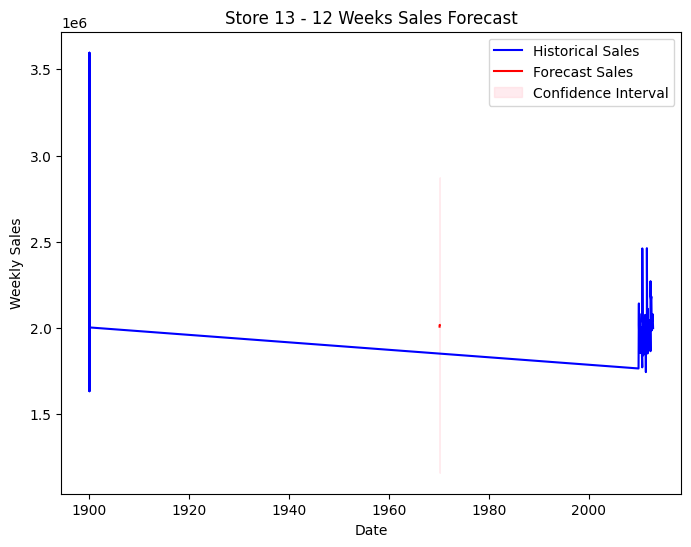

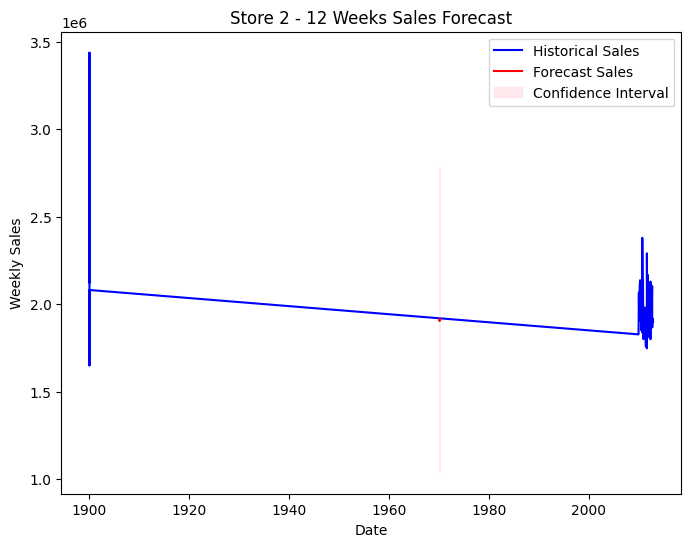

In [35]:
# ---------- Plot for Top 5 stores ----------
# Identify top 5 stores by mean sales (using the original df before any filtering for forecast)
top_stores = df.groupby('store')['weekly_sales'].mean().sort_values(ascending=False).head(5).index.tolist()

print("Plotting forecasts for the top 5 stores:", top_stores)

for store in top_stores:
    plot_store_forecast(store, df, forecast_results)


In [36]:
# Identify stores with non-monotonic dates
non_monotonic_stores = []
for store, g in df.groupby('store'):
    if not g['date'].is_monotonic_increasing:
        non_monotonic_stores.append(store)

print("Stores with non-monotonic dates:", non_monotonic_stores)


Stores with non-monotonic dates: []


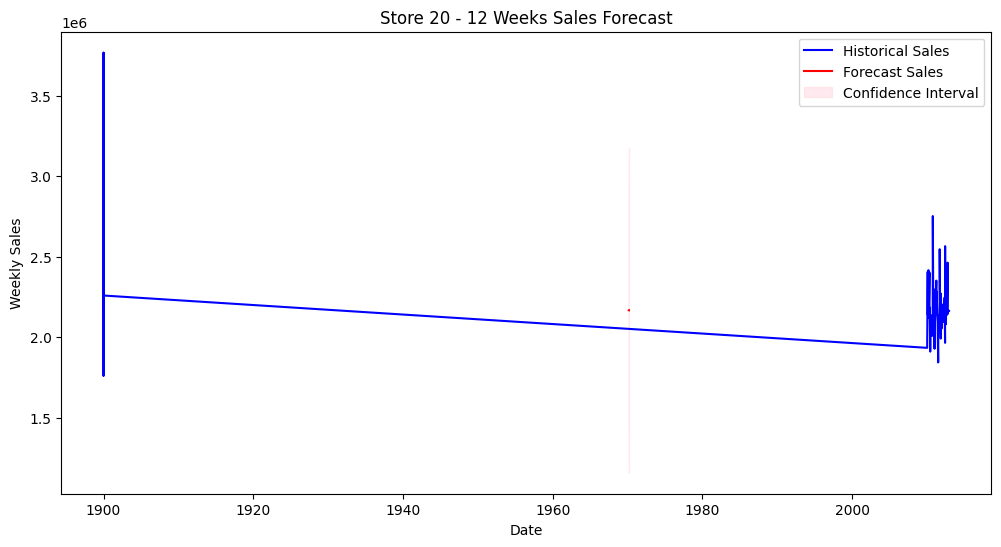

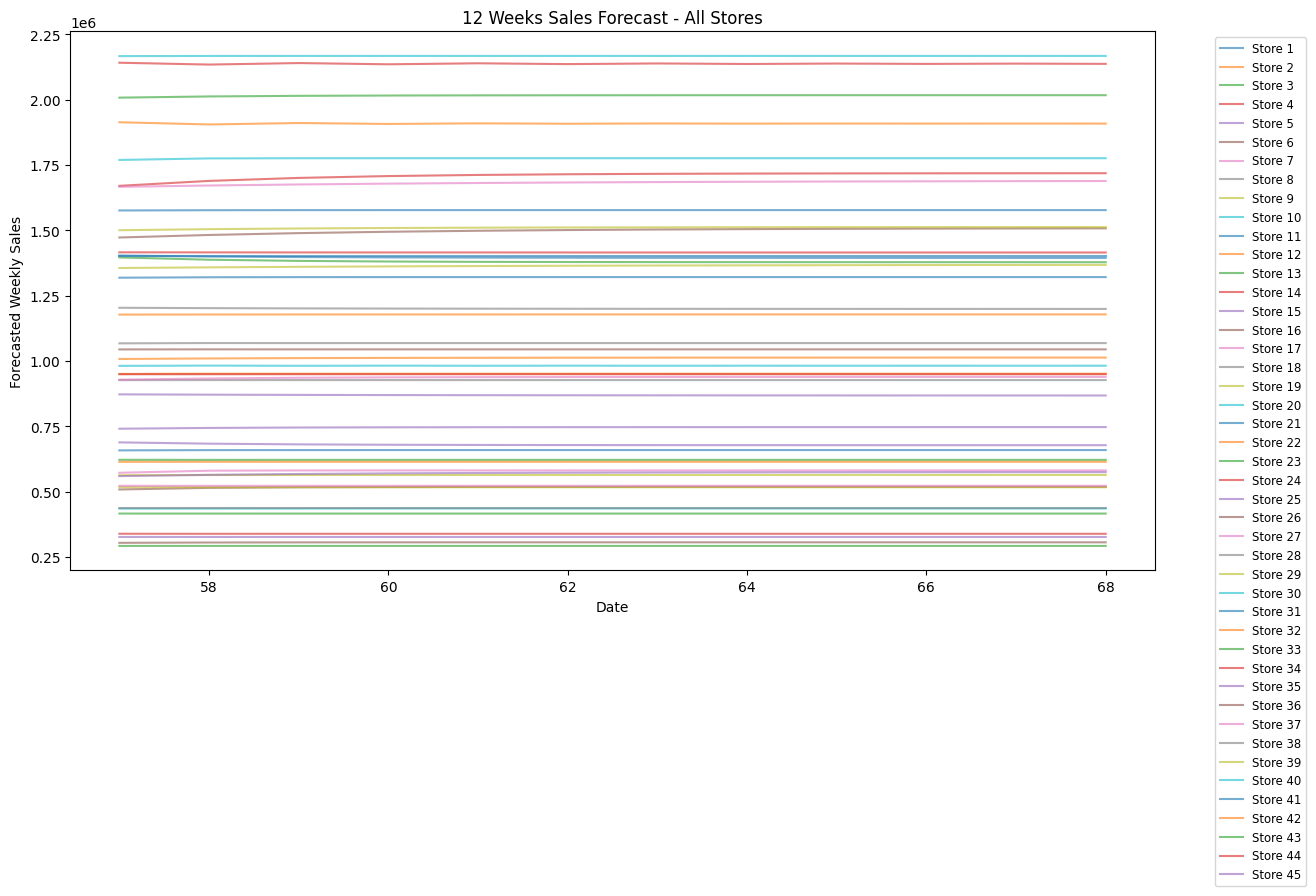

In [39]:
# Function to plot forecast for a given store
def plot_store_forecast(store_id, df, forecast_results):
    # Original data
    g = df[df['store'] == store_id][['date','weekly_sales']].sort_values('date')

    # Forecasted data (last 12 weeks)
    forecast = forecast_results[store_id]

    plt.figure(figsize=(12,6))

    # Plot historical sales
    plt.plot(g['date'], g['weekly_sales'], label='Historical Sales', color='blue')

    # Plot forecast line
    plt.plot(forecast.index, forecast['mean'], label='Forecast Sales', color='red')

    # Plot confidence interval
    plt.fill_between(forecast.index, forecast['mean_ci_lower'], forecast['mean_ci_upper'],
                     color='pink', alpha=0.3, label='Confidence Interval')

    plt.title(f"Store {store_id} - 12 Weeks Sales Forecast")
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales")
    plt.legend()
    plt.show()


    # Example: Plot forecast for Store 20
plot_store_forecast(20, df, forecast_results)

plt.figure(figsize=(14,7))

for store in forecast_results.keys():
    # Forecast line
    f = forecast_results[store]
    plt.plot(f.index, f['mean'], label=f"Store {store}", alpha=0.6) # Use f.index for dates and 'mean' for forecast

plt.title("12 Weeks Sales Forecast - All Stores")
plt.xlabel("Date")
plt.ylabel("Forecasted Weekly Sales")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()




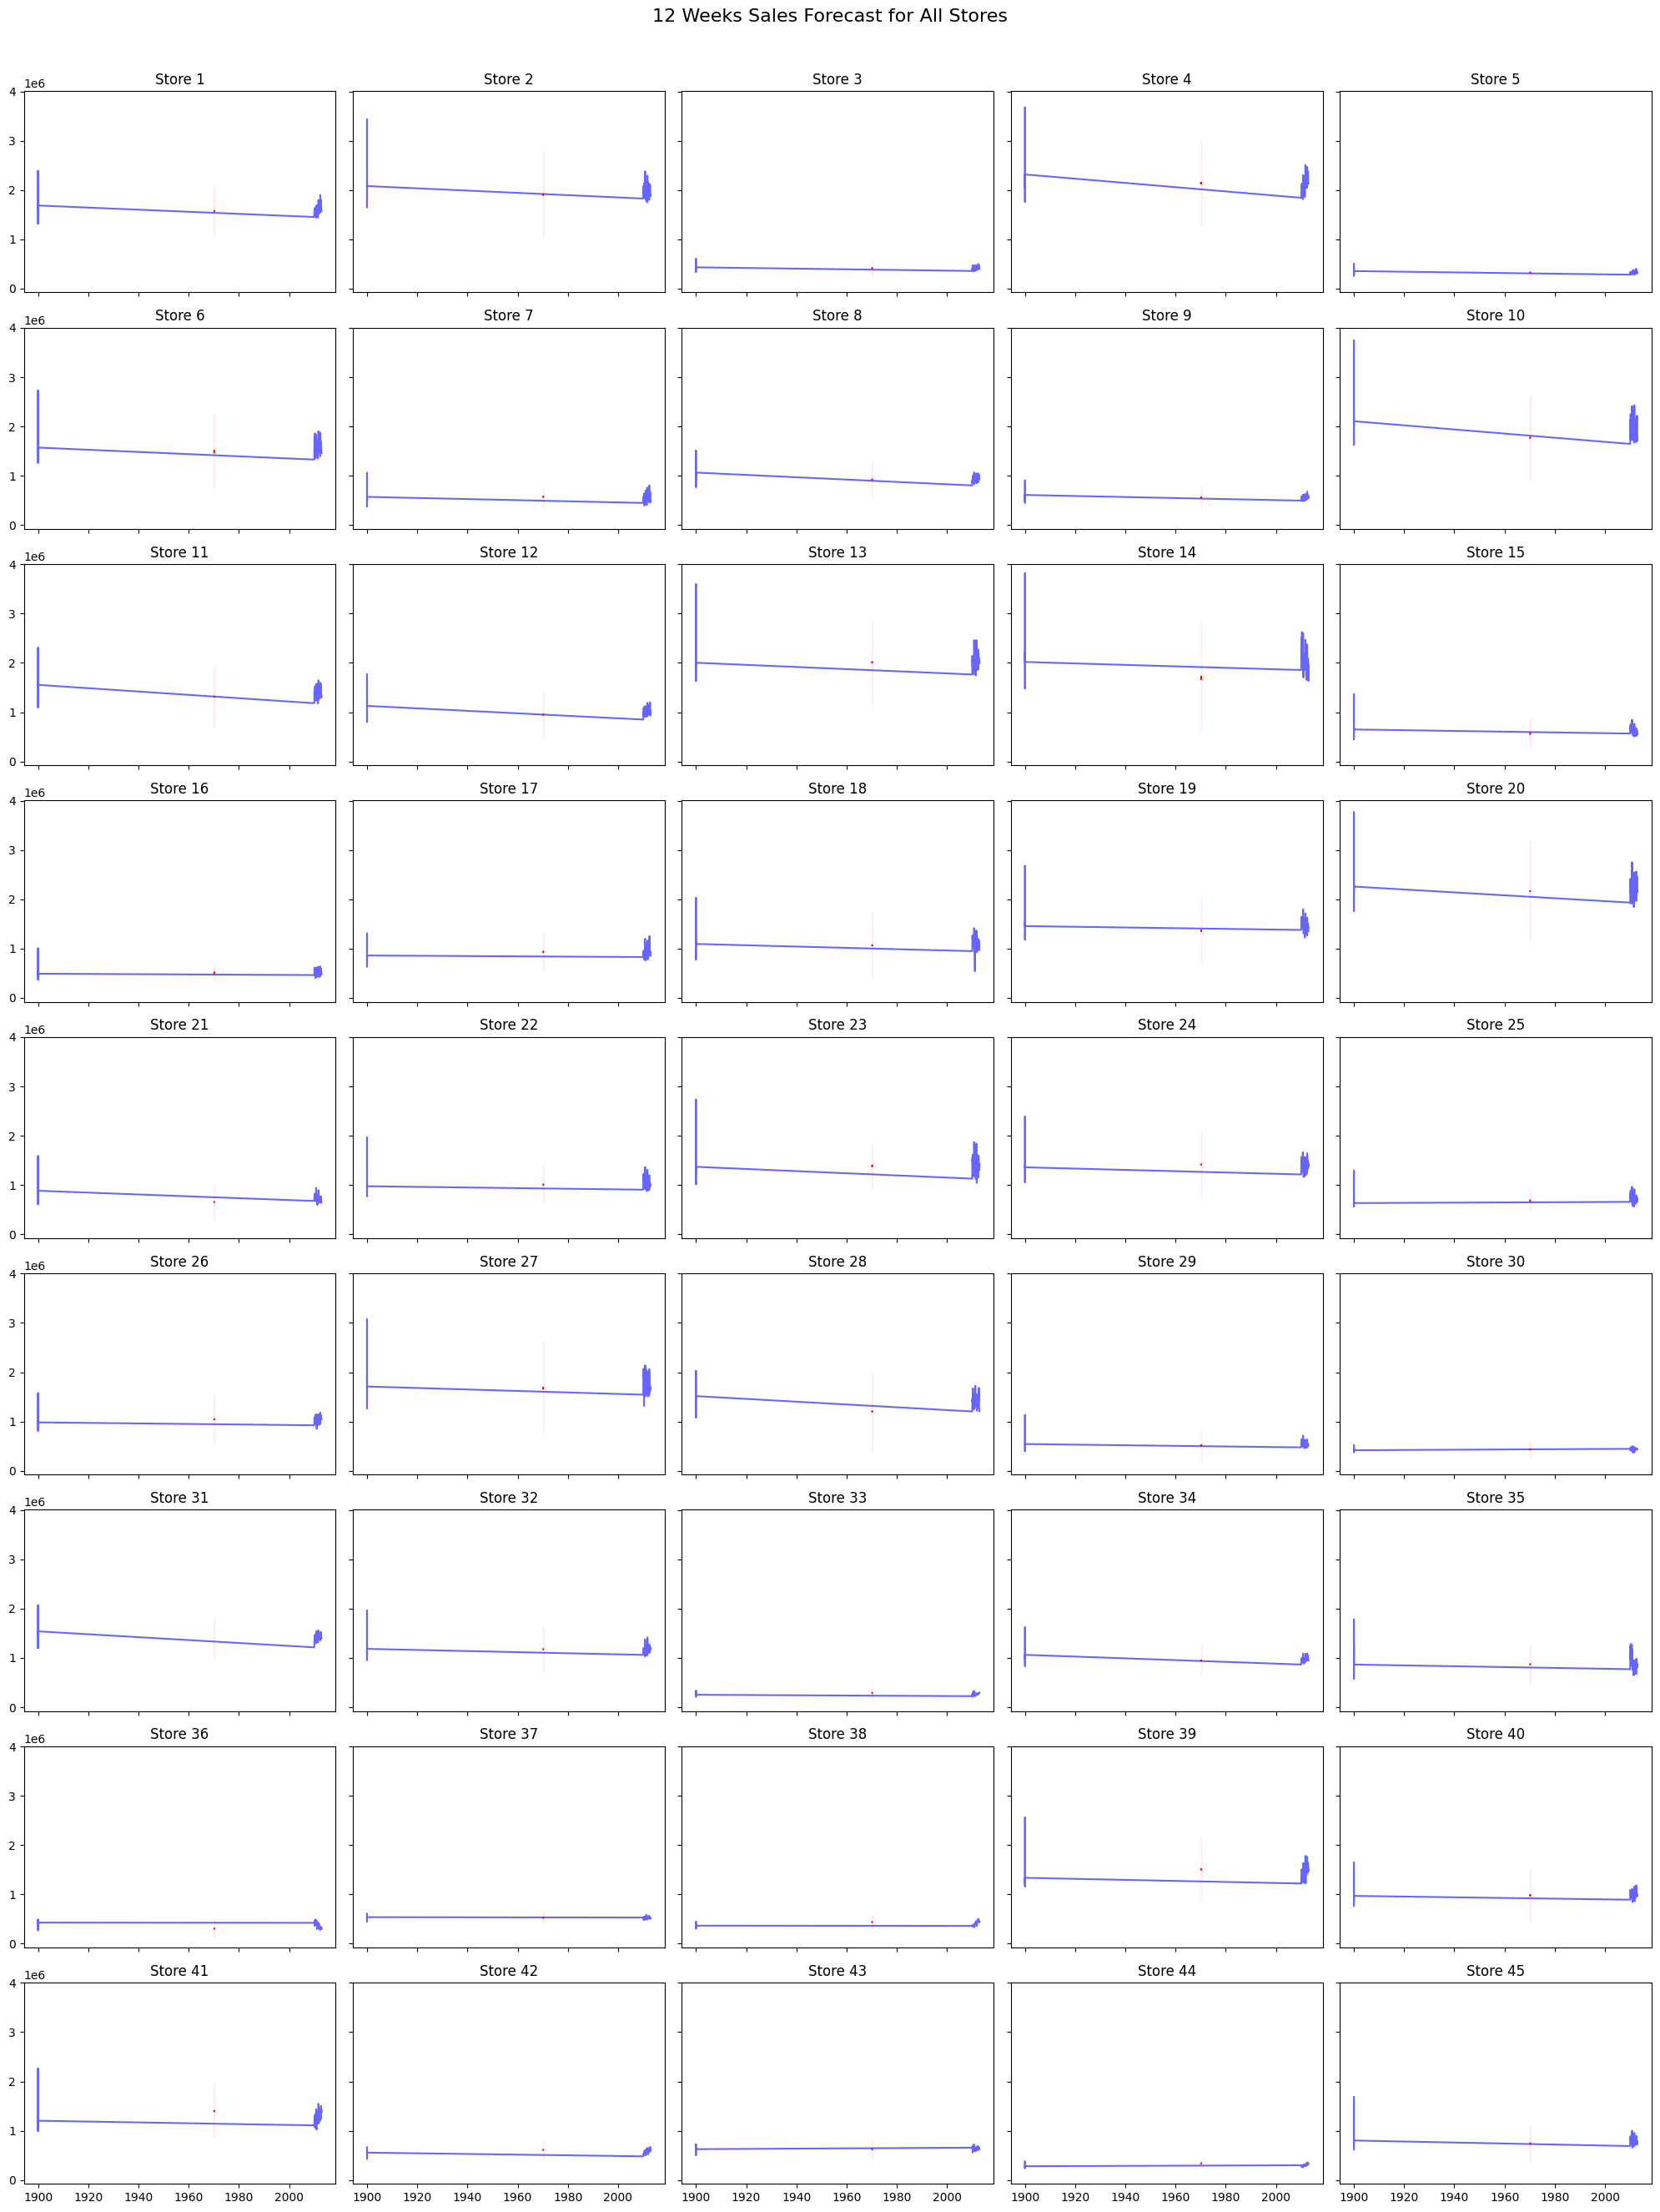

In [40]:
import math

stores = list(forecast_results.keys())
n = len(stores)

rows = math.ceil(n/5)  # 5 columns per row
cols = 5

fig, axes = plt.subplots(rows, cols, figsize=(20, rows*3), sharex=True, sharey=True)
axes = axes.flatten()

for i, store in enumerate(stores):
    g = df[df['store'] == store][['date','weekly_sales']].sort_values('date')
    f = forecast_results[store]

    axes[i].plot(g['date'], g['weekly_sales'], color='blue', alpha=0.6, label="Historical")
    axes[i].plot(f.index, f['mean'], color='red', label="Forecast") # Corrected column name
    axes[i].fill_between(f.index, f['mean_ci_lower'], f['mean_ci_upper'], color='pink', alpha=0.3) # Corrected column names
    axes[i].set_title(f"Store {store}")

# Remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("12 Weeks Sales Forecast for All Stores", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.97])
plt.show()